c:\Users\Biswajit Palit\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


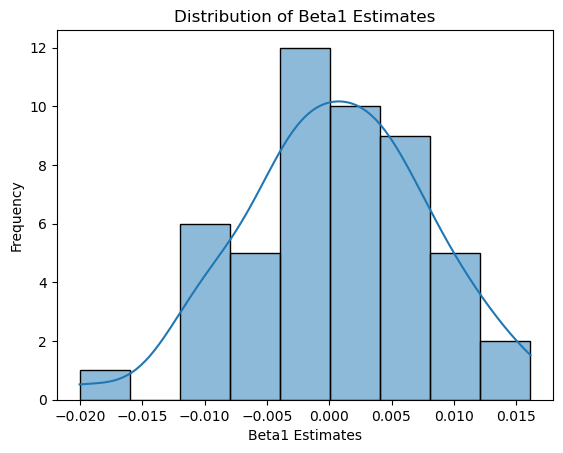

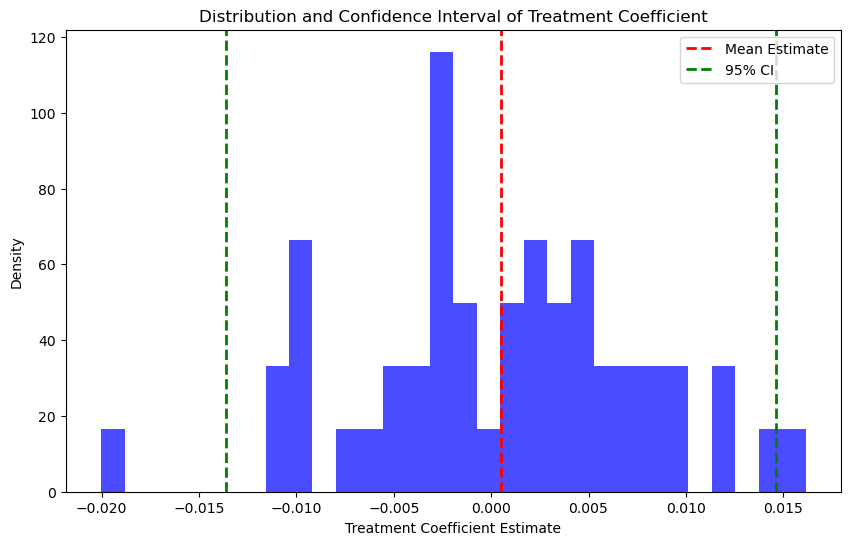

Number of times null hypothesis is rejected for : 2 out of 50 simulations
Type 1 Error: 0.04
Bias for Coefficient of Treatment (True Value = 0): 0.0004932180127168412
MSE for Coefficient of Treatment (True Value = 0): 0.0004010957358496923
Average RMSE for Coefficient of Treatment (True Value = 0): 0.0200273746619394
The confidence interval is (-0.013633306336534612, {0.014619742361968295})


In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from data_gen_Monte_Carlo_AR1 import (generate_staggered_law_ar1_data)

np.random.seed(42) 

beta1_estimates = []

reject_count = 0  # Counter for the number of rejections
alpha = 0.05  # Significance level
num_simulations = 50
bias_values = []
squared_error_values = []
N = 50
T = 20
rho = 0.4
num_individuals = 500

true_beta1_value = 0
standard_error_values = []

bias_values = []

for _ in range(num_simulations):
    data = generate_staggered_law_ar1_data( N, T, rho, num_individuals)

    cps_agg = data.groupby(['state', 'time'])[['value', 'TREATMENT']].mean().reset_index()

    # One-hot encode STATEFIP and YEAR
    dummy_df_state = pd.get_dummies(cps_agg['state'], prefix='state', drop_first=True)
    dummy_df_year = pd.get_dummies(cps_agg['time'], prefix='time', drop_first=True)

    # Concatenate the dummy variables with the original DataFrame
    cps_agg = pd.concat([cps_agg, dummy_df_state, dummy_df_year], axis=1)

    # Convert True and False to 1 and 0 in the specified columns
    boolean_columns = ['state_2', 'state_3', 'state_4', 'state_5',
       'state_6', 'state_7', 'state_8', 'state_9', 'state_10', 'state_11',
       'state_12', 'state_13', 'state_14', 'state_15', 'state_16', 'state_17',
       'state_18', 'state_19', 'state_20', 'state_21', 'state_22', 'state_23',
       'state_24', 'state_25', 'state_26', 'state_27', 'state_28', 'state_29',
       'state_30', 'state_31', 'state_32', 'state_33', 'state_34', 'state_35',
       'state_36', 'state_37', 'state_38', 'state_39', 'state_40', 'state_41',
       'state_42', 'state_43', 'state_44', 'state_45', 'state_46', 'state_47',
       'state_48', 'state_49', 'state_50', 'time_1', 'time_2', 'time_3',
       'time_4', 'time_5', 'time_6', 'time_7', 'time_8', 'time_9', 'time_10',
       'time_11', 'time_12', 'time_13', 'time_14', 'time_15', 'time_16',
       'time_17', 'time_18', 'time_19']

    cps_agg[boolean_columns] = cps_agg[boolean_columns].astype(int)

    data = cps_agg.copy()

    # Step 3: Perform the OLS regression
    X = data[['TREATMENT', 'state_2', 'state_3', 'state_4', 'state_5',
       'state_6', 'state_7', 'state_8', 'state_9', 'state_10', 'state_11',
       'state_12', 'state_13', 'state_14', 'state_15', 'state_16', 'state_17',
       'state_18', 'state_19', 'state_20', 'state_21', 'state_22', 'state_23',
       'state_24', 'state_25', 'state_26', 'state_27', 'state_28', 'state_29',
       'state_30', 'state_31', 'state_32', 'state_33', 'state_34', 'state_35',
       'state_36', 'state_37', 'state_38', 'state_39', 'state_40', 'state_41',
       'state_42', 'state_43', 'state_44', 'state_45', 'state_46', 'state_47',
       'state_48', 'state_49', 'state_50', 'time_1', 'time_2', 'time_3',
       'time_4', 'time_5', 'time_6', 'time_7', 'time_8', 'time_9', 'time_10',
       'time_11', 'time_12', 'time_13', 'time_14', 'time_15', 'time_16',
       'time_17', 'time_18', 'time_19']] # plus any other control variables
    X = sm.add_constant(X)
    Y = data['value'] # Replace 'outcome' with your dependent variable
    model = sm.OLS(Y, X).fit(cov_type='cluster', cov_kwds={'groups': data['state'].astype(str)})

    bias = model.params['TREATMENT'] - true_beta1_value
    
    bias_values.append(bias)

    squared_error = (model.params['TREATMENT'] - true_beta1_value) ** 2

    
    standard_error = model.bse['TREATMENT']
    standard_error_values.append(standard_error)
    beta1_estimates.append(model.params['TREATMENT'])
    
    
    # Check if null hypothesis for beta1 is rejected
    if model.pvalues['TREATMENT'] < alpha:
        reject_count += 1


type1_error = reject_count / num_simulations

average_bias = np.mean(bias_values)
average_mse = np.mean(squared_error)   
average_rmse = np.sqrt(average_mse)  
average_standard_error = np.mean(standard_error_values)   

std_error_beta_distribution = np.std(beta1_estimates)

sns.histplot(beta1_estimates, kde=True)
plt.xlabel('Beta1 Estimates')
plt.ylabel('Frequency')
plt.title('Distribution of Beta1 Estimates')
plt.show()

# Calculate the confidence interval
confidence_interval = (
    np.mean(beta1_estimates) - 1.96 * std_error_beta_distribution,
    np.mean(beta1_estimates) + 1.96 * std_error_beta_distribution
)
plt.figure(figsize=(10, 6))
plt.hist(beta1_estimates, bins=30, density=True, color='blue', alpha=0.7)
plt.axvline(np.mean(beta1_estimates), color='red', linestyle='dashed', linewidth=2, label='Mean Estimate')
plt.axvline(confidence_interval[0], color='green', linestyle='dashed', linewidth=2, label='95% CI')
plt.axvline(confidence_interval[1], color='green', linestyle='dashed', linewidth=2)
plt.xlabel('Treatment Coefficient Estimate')
plt.ylabel('Density')
plt.title('Distribution and Confidence Interval of Treatment Coefficient')
plt.legend()
plt.show()


# Print the number of rejections
# Print the number of rejections
print(f"Number of times null hypothesis is rejected for : {reject_count} out of {num_simulations} simulations")
print(f"Type 1 Error: {type1_error}")
print(f"Bias for Coefficient of Treatment (True Value = {true_beta1_value}): {average_bias}")
print(f"MSE for Coefficient of Treatment (True Value = {true_beta1_value}): {average_mse}")
print(f"Average RMSE for Coefficient of Treatment (True Value = {true_beta1_value}): {average_rmse}")
print(f'The confidence interval is {confidence_interval[0] , {confidence_interval[1]}}')




In [5]:
import pandas as pd
import numpy as np
import gzip

# Specify the path to the compressed CSV file
file_path = r'C:\Users\Biswajit Palit\Downloads\cps_00006.csv.gz'

def cps_data(file_path):
    # Use Pandas to read the compressed CSV file directly
    # The compression parameter is set to 'gzip'
    df = pd.read_csv(file_path, compression='gzip', header=0)

    # Drop rows where INCWAGE is 99999999
    df = df[(df['INCWAGE'] != 99999999) & (df['INCWAGE'] != 0) & (df['INCWAGE'] != 999)]
    df['INCWAGE'] = np.log(df['INCWAGE'])
    
    df = df[(df['EDUC'] != 0) & (df['EDUC'] != 1)]

    df = df[(df['YEAR'] >= 1980) & (df['YEAR'] <= 2000)]

    dummy_df = pd.get_dummies(df['YEAR'], prefix='YEAR', drop_first=True)
    df = pd.concat([df, dummy_df], axis=1)

    def categorize_education(educ_code):
        if educ_code <= 10:
            return 'Up to Grade 10'
        elif 10 < educ_code <= 70:
            return 'High School'
        elif 70 < educ_code <= 123:
            return "Master's Degree"
        else:
            return 'Doctorate Degree'

    # Apply the function to create a new 'Education_Category' column
    df['Education_Category'] = df['EDUC'].apply(categorize_education)
    df = pd.get_dummies(df, columns=['Education_Category'], prefix='', prefix_sep='', drop_first=True)

    df = df[~((df['STATEFIP'] > 56) | (df['STATEFIP'] == 11))]

    dummy_df = pd.get_dummies(df['STATEFIP'], prefix='STATEFIP', drop_first=True)
    df = pd.concat([df, dummy_df], axis=1)

    df = df[(df['AGE'] >= 25) & (df['AGE'] <= 50)]

    df = df[df['SEX'] == 2]

    boolean_columns = ['YEAR_1981', 'YEAR_1982',
                       'YEAR_1983', 'YEAR_1984', 'YEAR_1985', 'YEAR_1986', 'YEAR_1987',
                       'YEAR_1988', 'YEAR_1989', 'YEAR_1990', 'YEAR_1991', 'YEAR_1992',
                       'YEAR_1993', 'YEAR_1994', 'YEAR_1995', 'YEAR_1996', 'YEAR_1997',
                       'YEAR_1998', 'YEAR_1999', 'YEAR_2000', 'High School', "Master's Degree",
                       'Up to Grade 10', 'STATEFIP_2', 'STATEFIP_4', 'STATEFIP_5',
                       'STATEFIP_6', 'STATEFIP_8', 'STATEFIP_9', 'STATEFIP_10', 'STATEFIP_12',
                       'STATEFIP_13', 'STATEFIP_15', 'STATEFIP_16', 'STATEFIP_17',
                       'STATEFIP_18', 'STATEFIP_19', 'STATEFIP_20', 'STATEFIP_21',
                       'STATEFIP_22', 'STATEFIP_23', 'STATEFIP_24', 'STATEFIP_25',
                       'STATEFIP_26', 'STATEFIP_27', 'STATEFIP_28', 'STATEFIP_29',
                       'STATEFIP_30', 'STATEFIP_31', 'STATEFIP_32', 'STATEFIP_33',
                       'STATEFIP_34', 'STATEFIP_35', 'STATEFIP_36', 'STATEFIP_37',
                       'STATEFIP_38', 'STATEFIP_39', 'STATEFIP_40', 'STATEFIP_41',
                       'STATEFIP_42', 'STATEFIP_44', 'STATEFIP_45', 'STATEFIP_46',
                       'STATEFIP_47', 'STATEFIP_48', 'STATEFIP_49', 'STATEFIP_50',
                       'STATEFIP_51', 'STATEFIP_53', 'STATEFIP_54', 'STATEFIP_55',
                       'STATEFIP_56']

    # Convert True and False to 1 and 0 in the specified columns
    df[boolean_columns] = df[boolean_columns].astype(int)

    
    
    return df


In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

beta1_estimates = []
reject_count = 0  # Counter for the number of rejections
alpha = 0.05  # Significance level


bias_values = []


true_beta1_value = 0
squared_error_values = []
standard_error_values =[]
num_simulations = 20
file_path = r'C:\Users\Biswajit Palit\Downloads\cps_00006.csv.gz'
df = cps_data(file_path)
for _ in range(num_simulations):

    data = df.copy()

    model = smf.ols('INCWAGE ~ C(STATEFIP) + C(YEAR)', data=data)

    # Fit the model
    result = model.fit()

    data['u_hat'] = result.resid

    # Set your rho value
    rho = 0.8
    # Replace with your actual value

    # Generate initial shock for the year 1980
    data.loc[data['YEAR'] == 1980, 'shock'] = np.random.normal(size=len(data[data['YEAR'] == 1980]))

    # Generate shocks for subsequent years
    for year in range(1981, 2001):
        # For each state, calculate the shock
        for state in data['STATEFIP'].unique():
            prev_shock = data[(data['YEAR'] == year - 1) & (data['STATEFIP'] == state)]['shock'].values
            if len(prev_shock) >0:  # Check if previous year's data exists
                current_shock = rho * prev_shock[0] + np.random.normal()
                data.loc[(data['YEAR'] == year) & (data['STATEFIP'] == state), 'shock'] = current_shock


    data['INCWAGE'] = data['INCWAGE'] - data['u_hat'] + data['shock']
    
    X = data[['High School', "Master's Degree", 'AGE']]
    y = data['INCWAGE']

    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()

    # Obtain predicted values from the fitted model
    y_pred = model.predict(X)

    residuals = y - y_pred

    data['Residuals'] = residuals

    cps_agg = data.groupby(['STATEFIP', 'YEAR'])[['Residuals']].mean().reset_index()

    # One-hot encode STATEFIP and YEAR
    dummy_df_state = pd.get_dummies(cps_agg['STATEFIP'], prefix='STATEFIP', drop_first=True)
    dummy_df_year = pd.get_dummies(cps_agg['YEAR'], prefix='YEAR', drop_first=True)

    # Concatenate the dummy variables with the original DataFrame
    cps_agg = pd.concat([cps_agg, dummy_df_state, dummy_df_year], axis=1)

    # Convert True and False to 1 and 0 in the specified columns
    boolean_columns = ['STATEFIP_2', 'STATEFIP_4', 'STATEFIP_5', 'STATEFIP_6', 'STATEFIP_8', 'STATEFIP_9',
                        'STATEFIP_10', 'STATEFIP_12', 'STATEFIP_13', 'STATEFIP_15', 'STATEFIP_16', 'STATEFIP_17',
                        'STATEFIP_18', 'STATEFIP_19', 'STATEFIP_20', 'STATEFIP_21', 'STATEFIP_22', 'STATEFIP_23',
                        'STATEFIP_24', 'STATEFIP_25', 'STATEFIP_26', 'STATEFIP_27', 'STATEFIP_28', 'STATEFIP_29',
                        'STATEFIP_30', 'STATEFIP_31', 'STATEFIP_32', 'STATEFIP_33', 'STATEFIP_34', 'STATEFIP_35',
                        'STATEFIP_36', 'STATEFIP_37', 'STATEFIP_38', 'STATEFIP_39', 'STATEFIP_40', 'STATEFIP_41',
                        'STATEFIP_42', 'STATEFIP_44', 'STATEFIP_45', 'STATEFIP_46', 'STATEFIP_47', 'STATEFIP_48',
                        'STATEFIP_49', 'STATEFIP_50', 'STATEFIP_51', 'STATEFIP_53', 'STATEFIP_54', 'STATEFIP_55',
                        'STATEFIP_56', 'YEAR_1981', 'YEAR_1982', 'YEAR_1983', 'YEAR_1984', 'YEAR_1985', 'YEAR_1986',
                        'YEAR_1987', 'YEAR_1988', 'YEAR_1989', 'YEAR_1990', 'YEAR_1991', 'YEAR_1992', 'YEAR_1993',
                        'YEAR_1994', 'YEAR_1995', 'YEAR_1996', 'YEAR_1997', 'YEAR_1998', 'YEAR_1999', 'YEAR_2000']

    cps_agg[boolean_columns] = cps_agg[boolean_columns].astype(int)

    data = cps_agg.copy()

    states = data['STATEFIP'].unique()
    

    # Randomly select half of the states to be in the treatment group
    
    treatment_states = np.random.choice(states, size=len(states)//2, replace=False)

    # Assign treatment year to each treatment state, staggered between 1985 and 1995
    treatment_years = np.random.choice(range(1985, 1995), size=len(treatment_states), replace=True)
    state_to_treatment_year = dict(zip(treatment_states, treatment_years))

    # Add a treatment column to the DataFrame
    data['TREATMENT'] = data.apply(lambda x: 1 if x['STATEFIP'] in treatment_states and x['YEAR'] >= state_to_treatment_year[x['STATEFIP']] else 0, axis=1)

    X = data['TREATMENT'] # plus any other control variables
    X = sm.add_constant(X)
    Y = data['Residuals'] # Replace 'outcome' with your dependent variable
    model = sm.OLS(Y, X).fit(cov_type='cluster', cov_kwds={'groups': data['STATEFIP'].astype(str)})

    bias = model.params['TREATMENT'] - true_beta1_value
    
    bias_values.append(bias)

    squared_error = (model.params['TREATMENT'] - true_beta1_value) ** 2

    
    standard_error = model.bse['TREATMENT']
    standard_error_values.append(standard_error)
    beta1_estimates.append(model.params['TREATMENT'])
    
    
    # Check if null hypothesis for beta1 is rejected
    if model.pvalues['TREATMENT'] < alpha:
        reject_count += 1


type1_error = reject_count / num_simulations

average_bias = np.mean(bias_values)
average_mse = np.mean(squared_error)   
average_rmse = np.sqrt(average_mse)  
average_standard_error = np.mean(standard_error_values)   

std_error_beta_distribution = np.std(beta1_estimates)


average_bias = np.mean(bias_values)
average_mse = np.mean(squared_error)


# Print the number of rejections
print(f"Number of times null hypothesis is rejected : {reject_count} out of {num_simulations} simulations")
print(f"Power of the test: {type1_error * 100} %")
print(f"Bias for Coefficient of Treatment (True Value = {true_beta1_value}): {average_bias}")
print(f"MSE for Coefficient of Treatment (True Value = {true_beta1_value}): {average_mse}")

sns.histplot(beta1_estimates, kde=True)
plt.xlabel('Beta1 Estimates')
plt.ylabel('Frequency')
plt.title('Distribution of Beta1 Estimates')
plt.show()

KeyError: ('TREATMENT', 'STATEFIP_2', 'STATEFIP_4', 'STATEFIP_5', 'STATEFIP_6', 'STATEFIP_8', 'STATEFIP_9', 'STATEFIP_10', 'STATEFIP_12', 'STATEFIP_13', 'STATEFIP_15', 'STATEFIP_16', 'STATEFIP_17', 'STATEFIP_18', 'STATEFIP_19', 'STATEFIP_20', 'STATEFIP_21', 'STATEFIP_22', 'STATEFIP_23', 'STATEFIP_24', 'STATEFIP_25', 'STATEFIP_26', 'STATEFIP_27', 'STATEFIP_28', 'STATEFIP_29', 'STATEFIP_30', 'STATEFIP_31', 'STATEFIP_32', 'STATEFIP_33', 'STATEFIP_34', 'STATEFIP_35', 'STATEFIP_36', 'STATEFIP_37', 'STATEFIP_38', 'STATEFIP_39', 'STATEFIP_40', 'STATEFIP_41', 'STATEFIP_42', 'STATEFIP_44', 'STATEFIP_45', 'STATEFIP_46', 'STATEFIP_47', 'STATEFIP_48', 'STATEFIP_49', 'STATEFIP_50', 'STATEFIP_51', 'STATEFIP_53', 'STATEFIP_54', 'STATEFIP_55', 'STATEFIP_56', 'YEAR_1981', 'YEAR_1982', 'YEAR_1983', 'YEAR_1984', 'YEAR_1985', 'YEAR_1986', 'YEAR_1987', 'YEAR_1988', 'YEAR_1989', 'YEAR_1990', 'YEAR_1991', 'YEAR_1992', 'YEAR_1993', 'YEAR_1994', 'YEAR_1995', 'YEAR_1996', 'YEAR_1997', 'YEAR_1998', 'YEAR_1999', 'YEAR_2000')